# Census Folium Tutorial

## Kenneth Burchfiel

Released under the MIT license

This tutorial demonstrates how to use the functions in census_folium_viewer.py to generate interactive zip-, county-, and state-level choropleth maps based on census data and shapefiles from the US Census Bureau. Within the tutorial, I will generate maps of two data types: (1) median household income and (2) the percentage of households that consist of a married couple with at least one child below the age of 18.

The tutorial also demonstrates how to incorporate a custom vertical legend into Folium maps. These have advantages over the default horizontal legend in certain circumstances.

**Note**: Some files in this project (such as the zip-code-level HTML maps) were too large to upload to GitHub. You can instead access those files via the following Google Drive folder: https://drive.google.com/drive/folders/11h1jnaVOA5A6ubbOJnC-kPEvdnJU00yv?usp=sharing


Citation info for color_schemes_from_branca.json:

Source: https://github.com/python-visualization/branca/blob/master/branca/_schemes.json

I believe these schemes were originally created by Cynthia Brewer, and are licensed under the Apache License, Version 2.0. See http://www.personal.psu.edu/cab38/ColorBrewer/ColorBrewer_updates.html

## Preliminary steps

First, you'll need to download zip code, county, and state shapefiles from the US Census bureau: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

I used 2020 zip code shapefiles for this project, which are available here: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=ZIP+Code+Tabulation+Areas

See this note regarding use of the shapefiles: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2021/TGRSHP2021_TechDoc_Ch1.pdf

Once you download the shapefiles to your computer, extract them using an unzipping utility. The shapefile document within this unzipped folder ends in .shp; for the 2020 zip code data, the file name is tl_2020_us_zcta520.shp. 

It appears that the other files within this folder may also be used by Geopandas in the creation of GeoDataFrames, so I recommend accessing the file within the unzipped folder rather than copying it into your project folder.

This project already contains zip-, county-, and state-level US Census data for various demographic variables. I created these data files via my Census query tutorial available at https://github.com/kburchfiel/census_query_tutorial . The zip- and county-level data comes from the 2019 American Community Survey (5-year estimates), and the state-level data comes from the 2019 American Community Survey (1-year estimates).


In [1]:
import time
start_time = time.time()
import census_folium_viewer
import geopandas
import numpy as np
import pandas as pd
import folium

## Part 1: Zip Code-Level Maps

The following code block uses census_folium_viewer.py's prepare_zip_table() function to create a GeoDataFrame storing both zip code and census data. It took 53.5 seconds for the function to create a table, whereas importing a saved version of this file took only 7.6 seconds. Therefore, to save time, I edited the code block so that it would only regenerate the GeoDataFrame if instructed to do so.

I recommend reading the documentation in census_folium_viewer.py for prepare_zip_table so that you'll better understand the inputs used by this function.

The zip code census data file only includes zip codes with at least 1,000 households, preventing outliers in the data related to low sample sizes.

Note: on one day when using prepare_zip_table, I received the following error message:
"ImportError: the 'read_file' function requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: DLL load failed while importing ogrext: The specified module could not be found."
I received this error while using version 3.4.0 of GDAL and version 1.8.20 of fiona.
After trying a couple different uninstall/reinstall operations, I was able to resolve the error by force removing both GDAL and Fiona, then installing fiona 1.8.19 (as suggested by Abhiram at https://stackoverflow.com/a/69534619/13097194). Conda Forge installed GDAL 3.2.2 as part of this operation, and these two seem to work together well. (If you still run into issues with these package versions, try restarting your kernel and/or restarting your code editor.)

In [18]:
create_new_zip_census_table = True

if create_new_zip_census_table == True:

    zip_and_census_table = census_folium_viewer.prepare_zip_table(
        shapefile_path = r'C:\Users\kburc\Downloads\tl_2020_us_zcta520\tl_2020_us_zcta520.shp',
        shape_feature_name = 'ZCTA5CE20', tolerance = 0.005, data_path =
        'census_query_results_1k_plus_households.csv',
        data_feature_name = 'Zip')
    print("Exporting data:")
    zip_and_census_table.to_file('zip_and_census_table.geojson',
    driver = 'GeoJSON') 
    # The above line exports the GeoDataFrame created by prepare_zip_table 
    # so that it can be imported back into the program, which takes less time
    # than does recreating the GeoDataFrame.

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


After being stored within the project folder, this table gets re-read into Python. That way, the program will still function even if the above cell did not run.

In [3]:
zip_and_census_table = geopandas.read_file('zip_and_census_table.geojson')

First, I will create a map displaying median household income by zip code. (Note: I will exclude Puerto Rico from these maps so as to focus on the 50 US states and DC. Puerto Rico has the code 72 in the 'State' column of the merged zip code data table, hence the use of zip_and_census_table.query("State != 72") as the argument for the merged_data_table parameter.)

If you haven't done so already, I highly recommend reading the documentation for generate_map so that you'll know what inputs are necessary for the function to run correctly.

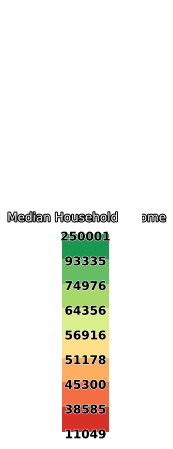

In [4]:
zip_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query("State != 72"),
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Median_household_income", feature_text = 'Zip Code',
    data_variable_text = 'Median Household Income',
    popup_variable_text = 'Income', 
    variable_decimals = None,
    map_name = 'zip_median_hh_income',
    fill_color = 'RdYlGn',
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 1, 
    vertical_legend = True)


In [5]:
# zip_median_hh_income_map

Next, I'll create a table showing the proportion of households in each zip code in the dataset that consist of a married couple with at least one child.

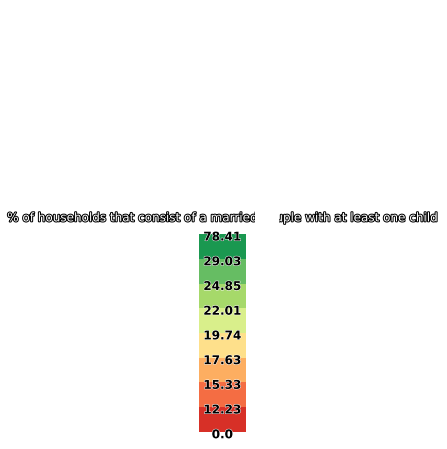

In [6]:
zip_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query("State != 72"),
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Married_couple_households_with_one_or_more_children_as_proportion_of_all_households",
    feature_text = 'Zip Code',
    data_variable_text= '% of households that consist of a married couple \
with at least one child',
    popup_variable_text = 'Percentage', 
    map_name = 'zip_married_couples_with_kids', fill_color = 'PuOr', 
    bin_count = 8,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

In [7]:
# zip_married_couples_with_children_map

## Part 2: County-Level Maps

The steps for generating county-level maps are similar. Note that the county census data file being imported only contains counties with at least 1,000 households.

In [8]:
county_and_census_table = census_folium_viewer.prepare_county_table(
    shapefile_path = r'C:\Users\kburc\Downloads\tl_2021_us_county\tl_2021_us_county.shp',
    shape_state_code_column = 'STATEFP', shape_county_code_column = 'COUNTYFP',
    tolerance = 0.005,
    data_path = 'census_county_query_results_1k_plus_households.csv',
    data_state_code_column = 'State', data_county_code_column = 'County_Code')
print("Exporting data:")
county_and_census_table.to_file('county_and_census_table.geojson',
    driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


In [9]:
county_and_census_table

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher
0,31,39,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,0.045677,0.000000,0.000000,0.350000,0.160377,0.000000,0.126228,0.361002,0.280452,0.232318
1,53,69,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,0.042202,0.086957,0.000000,0.113636,0.211538,0.000000,0.088401,0.291850,0.429467,0.190282
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,0.035193,0.016611,0.500516,0.329183,0.298510,0.113470,0.065179,0.219187,0.327854,0.387780
3,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,0.041565,0.032558,0.000000,0.288462,0.103448,0.000000,0.075611,0.386100,0.346847,0.191441
4,72,85,01804523,72085,Las Piedras,Las Piedras Municipio,13,H1,G4020,490,...,0.220447,0.112054,0.625731,0.617568,0.648975,0.334532,0.227354,0.269695,0.295435,0.207516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,...,0.049264,0.036855,0.661417,0.304478,0.159509,0.000000,0.180766,0.364277,0.254472,0.200485
3085,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,...,0.027640,0.027744,0.437500,0.453846,0.261364,0.452381,0.073030,0.348859,0.385087,0.193023
3086,28,89,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,0.022510,0.007988,0.371184,0.472291,0.263605,0.096855,0.081725,0.165932,0.275687,0.476656
3087,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,...,0.024122,0.020299,0.590909,0.351499,0.437500,0.000000,0.208250,0.335683,0.333120,0.122948


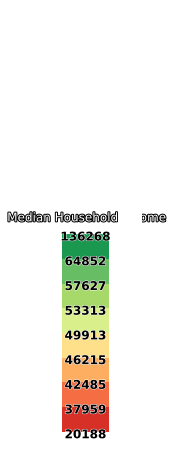

In [10]:
county_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("State != 72"), 
    shape_feature_name = 'County',
    data_variable = 'Median_household_income', feature_text = 'County',
    data_variable_text = 'Median Household Income',
    map_name = 'county_median_hh_income', 
    variable_decimals = None,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    popup_variable_text = 'Income (in 1000s)', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 1, 
    vertical_legend = True)

# county_hh_income_map

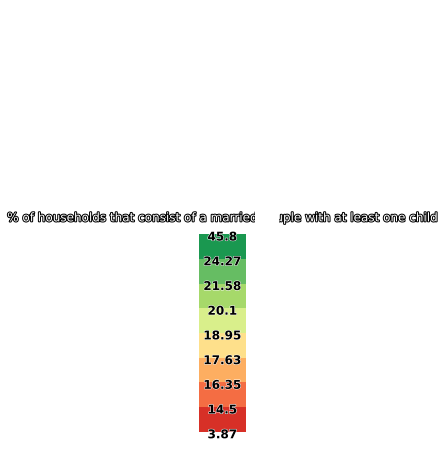

In [11]:
county_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("State != 72"),
    shape_feature_name = 'County',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households',
    feature_text = 'County', data_variable_text = '% of households \
that consist of a married couple with at least one child', 
    map_name = 'county_married_couples_with_kids', 
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', bin_count = 8,
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

# county_married_couples_with_children_map

# Part 3: State-Level Maps

Finally, I'll create state-level maps of median household income and married-couple family prevalence.

In [19]:
state_and_census_table = census_folium_viewer.prepare_state_table(
    shapefile_path = r'C:\Users\kburc\Downloads\tl_2020_us_state\tl_2020_us_state.shp', 
    shape_feature_name = 'NAME', tolerance = 0.005, data_path = 
    'census_state_query_results.csv', data_feature_name = 'State')
print("Exporting data:")
state_and_census_table.to_file('state_and_census_table.geojson',
driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


In [13]:
state_and_census_table

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,...,0.057931,0.023769,0.413344,0.376163,0.373349,0.142156,0.122257,0.396898,0.267613,0.213232
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,...,0.045651,0.031161,0.394851,0.285823,0.212984,0.122492,0.115130,0.286755,0.294417,0.303698
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,...,0.033936,0.014412,0.424809,0.314239,0.244137,0.087206,0.105070,0.260646,0.283657,0.350626
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,...,0.027502,0.011289,0.470846,0.255582,0.194563,0.085996,0.066366,0.241857,0.324740,0.367037
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,...,0.020924,0.011882,0.351742,0.255376,0.161751,0.057327,0.095056,0.242240,0.254603,0.408101
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,...,0.016368,0.018187,0.391927,0.292582,0.204000,0.086205,0.108798,0.284336,0.263053,0.343814
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,...,0.047341,0.028906,0.499500,0.352743,0.220500,0.089711,0.090814,0.278224,0.354448,0.276514
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,...,0.013395,0.009913,0.323511,0.299961,0.172399,0.122435,0.068514,0.277314,0.285818,0.368354
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,...,0.045724,0.017755,0.467438,0.345915,0.263536,0.088530,0.117553,0.253777,0.309499,0.319171
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,...,0.025879,0.018365,0.492143,0.302067,0.186669,0.087524,0.064831,0.285649,0.262397,0.387124


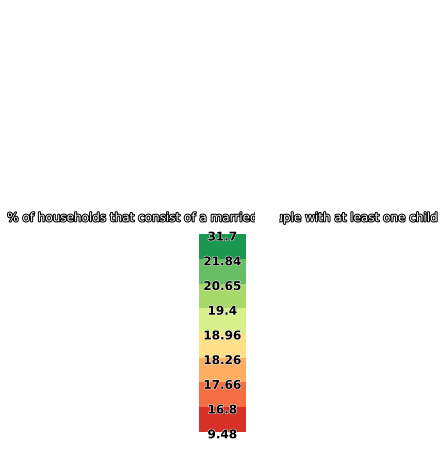

In [14]:
state_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("NAME != 'Puerto Rico'"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households', 
    feature_text = 'State', 
    data_variable_text = '% of households that consist of a married \
couple with at least one child', 
    map_name = 'state_married_couples_with_kids', 
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', 
    rows_to_map = 0, bin_type = 'percentiles', bin_count = 8, 
    multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

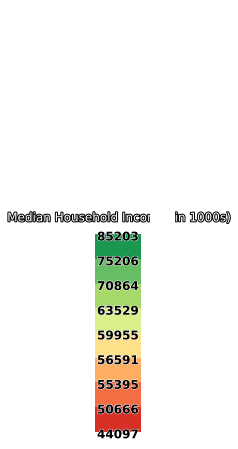

In [15]:
state_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("NAME != 'Puerto Rico'"), shape_feature_name = 'NAME',
    data_variable = 'Median_household_income', feature_text = 'State', 
    data_variable_text = 'Median Household Income (in 1000s)', 
    map_name = 'state_median_hh_income', 
    variable_decimals = None,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Income (in 1000s)', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 1, vertical_legend = True, 
    generate_image = True)

In [16]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish

Completed run at Sat Jan 15 18:03:29 2022 (local time)
Total run time: 266.12 second(s) (4.0 minute(s) and 26.12 second(s))
